## __Problem Statement__.  
Train a neural network to classify and localise cats and dogs in the Oxford-IIIT Pet Dataset.  
Link to the dataset - https://www.robots.ox.ac.uk/~vgg/data/pets/.  
The network to be trained would output the class and a single bounding box localising the object.

### Preparing the dataset

In [ ]:
# Importing libraries

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import cv2
import csv
import seaborn as sns
import glob
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
%matplotlib inline

Downloading the dataset and the annotations.

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

--2021-03-12 10:51:24--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2021-03-12 10:51:25--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  34.8MB/s    in 22s     

2021-03-12 10:51:47 (34.0 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]



In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2021-03-12 10:51:51--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz [following]
--2021-03-12 10:51:51--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  17.8MB/s    in 1.0s    

2021-03-12 10:51:52 (17.8 MB/s) - ‘annotations.tar.gz’ saved [19173078/19173078]



In [ ]:
!tar -xvf images.tar.gz
!tar -xvf annotations.tar.gz
!mv annotations/xmls/* images/

Streaming output truncated to the last 5000 lines.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian

_generate_dataset.py_ parses xml files which include the bounding box and the metadata required for the localisation problem, and writes it into  _csv_ files 

#### Dataset Generation

In [ ]:
%%writefile generate_dataset.py

import csv
import cv2
import glob
import os
import xml.etree.ElementTree as ET

import numpy as np

DATASET_FOLDER = "images/"
TRAIN_OUTPUT_FILE = "train.csv"
VALIDATION_OUTPUT_FILE = "validation.csv"

SPLIT_RATIO = 0.8

def main():
    if not os.path.exists(DATASET_FOLDER):
        print("Dataset not found")
        return

    class_names = {}
    k = 0
    output = []
    xml_files = glob.glob("{}/*xml".format(DATASET_FOLDER))
    for i, xml_file in enumerate(xml_files):
        tree = ET.parse(xml_file)
        path = os.path.join(tree.findtext("./filename"))
        name = str(tree.findtext("./object/name"))
        height = int(tree.findtext("./size/height"))
        width = int(tree.findtext("./size/width"))
        xmin = int(tree.findtext("./object/bndbox/xmin"))
        ymin = int(tree.findtext("./object/bndbox/ymin"))
        xmax = int(tree.findtext("./object/bndbox/xmax"))
        ymax = int(tree.findtext("./object/bndbox/ymax"))

        basename = os.path.basename(path)
        basename = os.path.splitext(basename)[0]
        class_name = basename[:basename.rfind("_")].lower()
        if class_name not in class_names:
            class_names[class_name] = k
            k += 1

        output.append((path, name, height, width, xmin, ymin, xmax, ymax, class_name, class_names[class_name]))

    # preserve percentage of samples for each class ("stratified")
    output.sort(key=lambda tup : tup[-1])

    lengths = []
    i = 0
    last = 0
    for j, row in enumerate(output):
        if last == row[-1]:
            i += 1
        else:
            print("class {}: {} images".format(output[j-1][-2], i))
            lengths.append(i)
            i = 1
            last += 1

    print("class {}: {} images".format(output[j-1][-2], i))
    lengths.append(i)

    with open(TRAIN_OUTPUT_FILE, "w") as train, open(VALIDATION_OUTPUT_FILE, "w") as validate:
        writer = csv.writer(train, delimiter=",")
        writer2 = csv.writer(validate, delimiter=",")

        s = 0
        for c in lengths:
            for i in range(c):
                print("{}/{}".format(s + 1, sum(lengths)), end="\r")

                path, name, height, width, xmin, ymin, xmax, ymax, class_name, class_id = output[s]

                if xmin >= xmax or ymin >= ymax or xmax > width or ymax > height or xmin < 0 or ymin < 0:
                    print("Warning: {} contains invalid box. Skipped...".format(path))
                    continue

                row = [path, name, height, width, xmin, ymin, xmax, ymax, class_name]
                if i <= c * SPLIT_RATIO:
                    writer.writerow(row)
                else:
                    writer2.writerow(row)

                s += 1

    print("\nDone!")

if __name__ == "__main__":
    main()

Writing generate_dataset.py


In [ ]:
!python3 generate_dataset.py

class english_cocker_spaniel: 100 images
class chihuahua: 100 images
class american_pit_bull_terrier: 100 images
class shiba_inu: 100 images
class newfoundland: 100 images
class english_setter: 100 images
class beagle: 100 images
class ragdoll: 99 images
class maine_coon: 100 images
class egyptian_mau: 92 images
class pomeranian: 100 images
class british_shorthair: 100 images
class persian: 100 images
class siamese: 100 images
class boxer: 100 images
class saint_bernard: 99 images
class basset_hound: 100 images
class bengal: 98 images
class american_bulldog: 100 images
class sphynx: 100 images
class great_pyrenees: 100 images
class japanese_chin: 100 images
class leonberger: 100 images
class russian_blue: 100 images
class scottish_terrier: 100 images
class yorkshire_terrier: 100 images
class miniature_pinscher: 100 images
class staffordshire_bull_terrier: 100 images
class havanese: 100 images
class bombay: 100 images
class abyssinian: 99 images
class keeshond: 100 images
class german_s

As per PASCAL VOC format, the bounding box co-ordinates in file are top-left _(xmin,ymin)_ and bottom-right _(xmax,ymax)_

In [ ]:
column =  ['filename', 'cat/dog', 'height', 'width', 'xmin', 'ymin', 'xmax', 'ymax', 'breed']
train_df = pd.read_csv('train.csv', header= None)
test_df = pd.read_csv('validation.csv', header = None)

In [ ]:
train_df.shape , test_df.shape

((2984, 9), (702, 9))

In [ ]:
train_df.columns = column
test_df.columns = column

In [ ]:
train_df.head()

,filename,cat/dog,height,width,xmin,ymin,xmax,ymax,breed
0,english_cocker_spaniel_123.jpg,dog,302,403,26,147,236,289,english_cocker_spaniel
1,english_cocker_spaniel_173.jpg,dog,375,500,57,70,223,225,english_cocker_spaniel
2,english_cocker_spaniel_125.jpg,dog,375,500,204,92,292,185,english_cocker_spaniel
3,english_cocker_spaniel_100.jpg,dog,375,500,239,77,471,340,english_cocker_spaniel
4,english_cocker_spaniel_167.jpg,dog,375,500,164,177,249,278,english_cocker_spaniel


In [ ]:
train_df['breed'].value_counts()

chihuahua                     81
siamese                       81
shiba_inu                     81
persian                       81
newfoundland                  81
bombay                        81
japanese_chin                 81
british_shorthair             81
english_setter                81
wheaten_terrier               81
maine_coon                    81
basset_hound                  81
great_pyrenees                81
miniature_pinscher            81
russian_blue                  81
beagle                        81
sphynx                        81
scottish_terrier              81
keeshond                      81
english_cocker_spaniel        81
american_bulldog              81
boxer                         81
yorkshire_terrier             81
leonberger                    81
birman                        81
havanese                      81
pug                           81
german_shorthaired            81
staffordshire_bull_terrier    81
american_pit_bull_terrier     81
pomeranian

In [ ]:
train_df["breed"] = train_df["breed"].astype('category')
train_df["label"] = train_df["breed"].cat.codes

In [ ]:
d = dict(enumerate(train_df["breed"].cat.categories))

In [ ]:
d

{0: 'abyssinian',
 1: 'american_bulldog',
 2: 'american_pit_bull_terrier',
 3: 'basset_hound',
 4: 'beagle',
 5: 'bengal',
 6: 'birman',
 7: 'bombay',
 8: 'boxer',
 9: 'british_shorthair',
 10: 'chihuahua',
 11: 'egyptian_mau',
 12: 'english_cocker_spaniel',
 13: 'english_setter',
 14: 'german_shorthaired',
 15: 'great_pyrenees',
 16: 'havanese',
 17: 'japanese_chin',
 18: 'keeshond',
 19: 'leonberger',
 20: 'maine_coon',
 21: 'miniature_pinscher',
 22: 'newfoundland',
 23: 'persian',
 24: 'pomeranian',
 25: 'pug',
 26: 'ragdoll',
 27: 'russian_blue',
 28: 'saint_bernard',
 29: 'samoyed',
 30: 'scottish_terrier',
 31: 'shiba_inu',
 32: 'siamese',
 33: 'sphynx',
 34: 'staffordshire_bull_terrier',
 35: 'wheaten_terrier',
 36: 'yorkshire_terrier'}

In [ ]:
inv_map = {v: k for k, v in d.items()}

In [ ]:
test_df['breed'] = test_df['breed'].astype('category')
test_df['label'] = test_df['breed'].map(inv_map)

In [ ]:
train_df.head()

,filename,cat/dog,height,width,xmin,ymin,xmax,ymax,breed,label
0,english_cocker_spaniel_123.jpg,dog,302,403,26,147,236,289,english_cocker_spaniel,12
1,english_cocker_spaniel_173.jpg,dog,375,500,57,70,223,225,english_cocker_spaniel,12
2,english_cocker_spaniel_125.jpg,dog,375,500,204,92,292,185,english_cocker_spaniel,12
3,english_cocker_spaniel_100.jpg,dog,375,500,239,77,471,340,english_cocker_spaniel,12
4,english_cocker_spaniel_167.jpg,dog,375,500,164,177,249,278,english_cocker_spaniel,12


### Preprocessing Images

In [ ]:
import imageio
import imgaug as ia
from imgaug import augmenters as iaa 
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
%matplotlib inline
ia.seed(1)

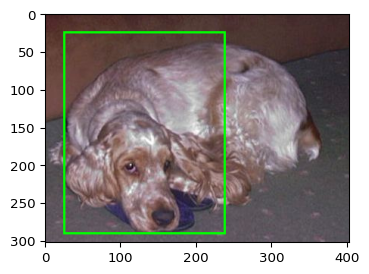

In [ ]:
image = imageio.imread('images/english_cocker_spaniel_123.jpg')
bbs = BoundingBoxesOnImage([BoundingBox(x1=26, x2=236, y1=26, y2=289)], shape=image.shape)
ia.imshow(bbs.draw_on_image(image, size=3))

In [ ]:
ia.seed(1)

seq = iaa.Sequential([
    iaa.Resize((300,300))
])

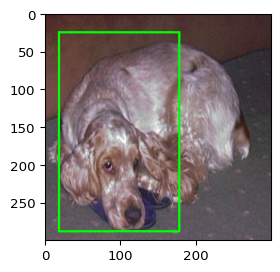

In [ ]:
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
ia.imshow(bbs_aug.draw_on_image(image_aug, size=3))

In [ ]:
bbs_aug.to_xyxy_array()[0]

array([ 19.354837,  25.827816, 175.68239 , 287.0861  ], dtype=float32)

#### Bounding Box Augumentation
For our modeling purposes, all the images will be resized to a fixed height and width, so as to pass it on as a tensor units for model training and inference.  
In process of resizing the image, the corresponding bounding box co-ordinates also change accordingly.   
To make sure our bounding box is aligned with the resized image, we use  the functionality _imgaug_ library - An Image Augumentation Library

In [ ]:
DATASET_FOLDER = "images/"
def augumenting_bbox(df, SIZE):
  bbox = []
  for _, j in df.iterrows():
    filename = j['filename']
    h = j['height']
    w = j['width']
    xmin = j['xmin']
    ymin = j['ymin']
    xmax = j['xmax']
    ymax = j['ymax']
    image = imageio.imread(DATASET_FOLDER + filename)
    bbs = BoundingBoxesOnImage([BoundingBox(x1= xmin, x2=xmax, y1=ymin, y2=ymax)], shape= (h,w,3))
    seq = iaa.Sequential([iaa.Resize((SIZE))])
    image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
    x1,y1,x2,y2 = bbs_aug.to_xyxy_array()[0]
    bbox.append([x1,y1,x2,y2])
  return bbox

In [ ]:
aug_bbox_train = augumenting_bbox(df= train_df, SIZE = (300,300))
aug_bbox_test = augumenting_bbox(df = test_df, SIZE = (300,300))

In [ ]:
len(aug_bbox_train), len(aug_bbox_test)

(2984, 702)

In [ ]:
bbox_train = pd.DataFrame(aug_bbox_train, columns= ['xmin_aug','ymin_aug','xmax_aug','ymax_aug'])
bbox_test = pd.DataFrame(aug_bbox_test, columns= ['xmin_aug','ymin_aug','xmax_aug','ymax_aug'])

In [ ]:
train_image_names = train_df['filename'].values
train_labels = train_df['label'].values
train_bbox = bbox_train[['xmin_aug','ymin_aug','xmax_aug','ymax_aug']].values

test_image_names = test_df['filename'].values
test_labels = test_df['label'].values
test_bbox = bbox_test[['xmin_aug','ymin_aug','xmax_aug','ymax_aug']].values

#### Train and Validation Set Generator Functions

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
DATA_PATH = '/content/images/'
IMG_SIZE = [300,300]

@tf.function
def preprocess_train(image_name, label, bbox):
    image = tf.io.read_file(DATA_PATH+image_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image,IMG_SIZE)
    return image, {'class_output': label, 'bbox_output': bbox}

@tf.function
def preprocess_test(image_name, label, bbox):
    image = tf.io.read_file(DATA_PATH+image_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    return image, {'class_output': label, 'bbox_output': bbox}

In [ ]:
trainloader = tf.data.Dataset.from_tensor_slices((train_image_names, train_labels, train_bbox))
testloader = tf.data.Dataset.from_tensor_slices((test_image_names, test_labels, test_bbox))

trainloader = (
    trainloader
    .map(preprocess_train, num_parallel_calls=AUTO)
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

### Modeling

In [ ]:
train_df.head()

,filename,cat/dog,height,width,xmin,ymin,xmax,ymax,breed,label
0,english_cocker_spaniel_123.jpg,dog,302,403,26,147,236,289,english_cocker_spaniel,12
1,english_cocker_spaniel_173.jpg,dog,375,500,57,70,223,225,english_cocker_spaniel,12
2,english_cocker_spaniel_125.jpg,dog,375,500,204,92,292,185,english_cocker_spaniel,12
3,english_cocker_spaniel_100.jpg,dog,375,500,239,77,471,340,english_cocker_spaniel,12
4,english_cocker_spaniel_167.jpg,dog,375,500,164,177,249,278,english_cocker_spaniel,12


In [ ]:
NUM_CLASS = train_df['label'].nunique()

#### MobileNetV2 Initialisation

In [ ]:
MobileNetV2 = tf.keras.applications.MobileNetV2(input_shape= (300,300,3), include_top= False, weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
for layer in MobileNetV2.layers:
   layer.trainable = False
base_model_output = MobileNetV2.output

In [ ]:
# NASNetMobile = tf.keras.applications.NASNetMobile(input_shape=(224,224,3), include_top= False, weights='imagenet')

19996672/19993432 [==============================] - 0s 0us/step


In [ ]:
# for layer in NASNetMobile.layers:
#    layer.trainable = False
# base_model_output = NASNetMobile.output

#### Custom Sequential Model 

In [ ]:
flattened_output = tf.keras.layers.GlobalAveragePooling2D()(base_model_output)

# classification-head
class_predict = tf.keras.layers.Dense(128, activation='relu')(flattened_output)
class_predict = tf.keras.layers.Dropout(0.2)(class_predict)
class_predict = tf.keras.layers.Dense(64, activation='relu')(class_predict)
class_predict = tf.keras.layers.Dropout(0.2)(class_predict)
class_output = tf.keras.layers.Dense(NUM_CLASS, activation= 'softmax', name = 'class_output')(class_predict)

# regression-head
bbox_predict = tf.keras.layers.Dense(512, activation='relu')(flattened_output)
bbox_predict = tf.keras.layers.Dropout(0.2)(bbox_predict)
bbox_predict = tf.keras.layers.Dense(256, activation='relu')(bbox_predict)
bbox_predict = tf.keras.layers.Dropout(0.2)(bbox_predict)
bbox_predict = tf.keras.layers.Dense(128, activation='relu')(bbox_predict)
bbox_predict = tf.keras.layers.Dropout(0.2)(bbox_predict)
bbox_output = tf.keras.layers.Dense(4, activation= None, name = 'bbox_output')(bbox_predict)

In [ ]:
model = tf.keras.Model(inputs = MobileNetV2.input, outputs = [class_output,bbox_output])

In [ ]:
!mkdir model_chkpt

mkdir: cannot create directory ‘model_chkpt’: File exists


In [ ]:
checkpoint_filepath = '/content/model_chkpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    mode='auto',
    save_freq = 5)

In [ ]:
learningrate_callbck = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.00001
)

In [ ]:
# tf.keras.utils.plot_model(
#     model, to_file='model.png', show_shapes=True, show_layer_names=True,
#     rankdir='TB', expand_nested=True, dpi=96
# )

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model.compile(optimizer= optimizer, 
              loss = {'class_output' : tf.keras.losses.SparseCategoricalCrossentropy(), 'bbox_output': tf.keras.losses.MeanSquaredError()},
              loss_weights = {'class_output' : 1.0 , 'bbox_output' : 2.0}, 
              metrics = {'class_output': 'accuracy', 'bbox_output' : tf.keras.metrics.RootMeanSquaredError()})

In [ ]:
history = model.fit(trainloader, epochs=100, validation_data=testloader, callbacks= [model_checkpoint_callback, learningrate_callbck])

Epoch 1/100
94/94 [==============================] - 21s 169ms/step - loss: 10980.5117 - class_output_loss: 3.5480 - bbox_output_loss: 5488.4814 - class_output_accuracy: 0.0433 - bbox_output_root_mean_squared_error: 71.7569 - val_loss: 2141.5002 - val_class_output_loss: 3.6389 - val_bbox_output_loss: 1068.9305 - val_class_output_accuracy: 0.0413 - val_bbox_output_root_mean_squared_error: 32.6945
Epoch 2/100
94/94 [==============================] - 16s 152ms/step - loss: 2819.5722 - class_output_loss: 3.6025 - bbox_output_loss: 1407.9846 - class_output_accuracy: 0.0419 - bbox_output_root_mean_squared_error: 37.5185 - val_loss: 2128.6409 - val_class_output_loss: 3.5760 - val_bbox_output_loss: 1062.5326 - val_class_output_accuracy: 0.0442 - val_bbox_output_root_mean_squared_error: 32.5965
Epoch 3/100
94/94 [==============================] - 16s 151ms/step - loss: 2711.0131 - class_output_loss: 3.5485 - bbox_output_loss: 1353.7324 - class_output_accuracy: 0.0439 - bbox_output_root_mean_squ

In [ ]:
history.history.keys()

dict_keys(['loss', 'class_output_loss', 'bbox_output_loss', 'class_output_accuracy', 'bbox_output_root_mean_squared_error', 'val_loss', 'val_class_output_loss', 'val_bbox_output_loss', 'val_class_output_accuracy', 'val_bbox_output_root_mean_squared_error', 'lr'])

#### Evaluation Plots

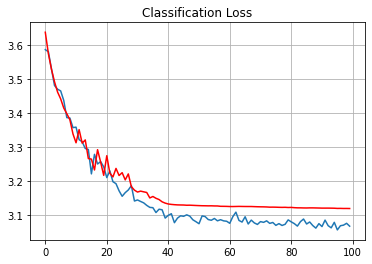

In [ ]:
plt.plot(history.history['class_output_loss'])
plt.plot(history.history['val_class_output_loss'], color = 'r')
plt.title('Classification Loss')
plt.grid()

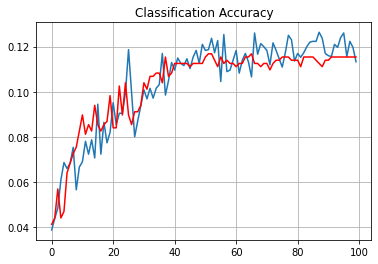

In [ ]:
plt.plot(history.history['class_output_accuracy'])
plt.plot(history.history['val_class_output_accuracy'], color = 'r')
plt.title('Classification Accuracy')
plt.grid()

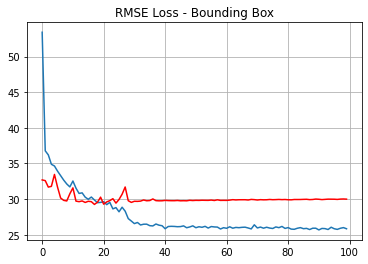

In [ ]:
plt.plot(history.history['bbox_output_root_mean_squared_error'])
plt.plot(history.history['val_bbox_output_root_mean_squared_error'], color = 'r')
plt.title('RMSE Loss - Bounding Box')
plt.grid()

### Prediction

In [ ]:
file1 = open('/content/annotations/test.txt', 'r')
test_image_list = []
count = 0 
while True:
  count += 1
  line = file1.readline()
  if not line:
    break
  else:
    name_img = line.split()[0]
    final_name = name_img + '.jpg'
    test_image_list.append(final_name)
file1.close()

In [ ]:
len(test_image_list)

3669

In [ ]:
DATA_PATH = '/content/images/'
@tf.function
def preprocess_predict(image_name):
    image = tf.io.read_file(DATA_PATH+image_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [300,300])
    return image

predloader = tf.data.Dataset.from_tensor_slices((test_image_list))

In [ ]:
predloader = (predloader.map(preprocess_predict).batch(32))

In [ ]:
class_label, bbox_label = model.predict(predloader)

In [ ]:
len(class_label)

3669

In [ ]:
d[np.argmax(class_label[0])]

'pug'

Enter a random number between 0-3669

Enter a random number: 100


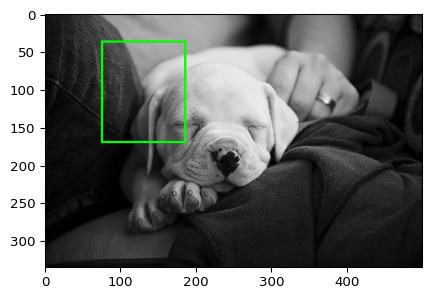

Predicted Label:  american_bulldog
True Label:  american_bulldog_207.jpg


In [ ]:
i = int(input('Enter a random number: '))
x1,y1,x2,y2 = bbox_label[i]
image = imageio.imread(DATA_PATH + test_image_list[i])
bbs = BoundingBoxesOnImage([BoundingBox(x1=x1, x2=x2, y1=y1, y2=y2)], shape=image.shape)
ia.imshow(bbs.draw_on_image(image, size=3))
print('Predicted Label: ', d[np.argmax(class_label[i])])
print('True Label: ',test_image_list[i])